<a href="https://colab.research.google.com/github/davorrunje/websummercamp2025/blob/main/03_Tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tools

Install the AG2 Python package first:

In [1]:
!pip install ag2[openai]

Next, get the API key and create an LLM configuration.

In [2]:
import os
from autogen import LLMConfig
from google.colab import userdata

# Get the API key
api_key = userdata.get('OPENAI_API_KEY')
assert api_key.startswith("sk-")


llm_config = LLMConfig(
    api_type="openai",     # The provider
    model="gpt-4o-mini",   # The specific model
    api_key=api_key,       # Authentication
)

llm_config

LLMConfig(config_list=[{'api_type': 'openai', 'model': 'gpt-4o-mini', 'api_key': '**********', 'tags': []}])

In our financial compliance example, we've built a system that can process transactions, flag suspicious ones for human approval, and generate summary reports. But what if we need to check for duplicate payments? Our agents currently have no way to access historical transaction data or perform specific calculations outside their knowledge.

This is where tools come in - they bridge the gap between your agents' intelligence and the external world.

### The Need for Specialized Tools

As our financial compliance system evolves, we might need to:

- Check new transactions against a database of past payments
- Calculate risk scores based on complex algorithms
- Connect to third-party fraud detection APIs
- Access internal company systems and databases

These tasks go beyond what an LLM can do with just its internal knowledge, requiring specialized functionality that connects to external systems.

### How Tool Usage Works in AG2

Tool usage in AG2 follows a simple but powerful two-step process:

- Selection: An agent (driven by its LLM) decides which tool is appropriate based on the given task
- Execution: A separate executor agent invokes the tool and returns the results

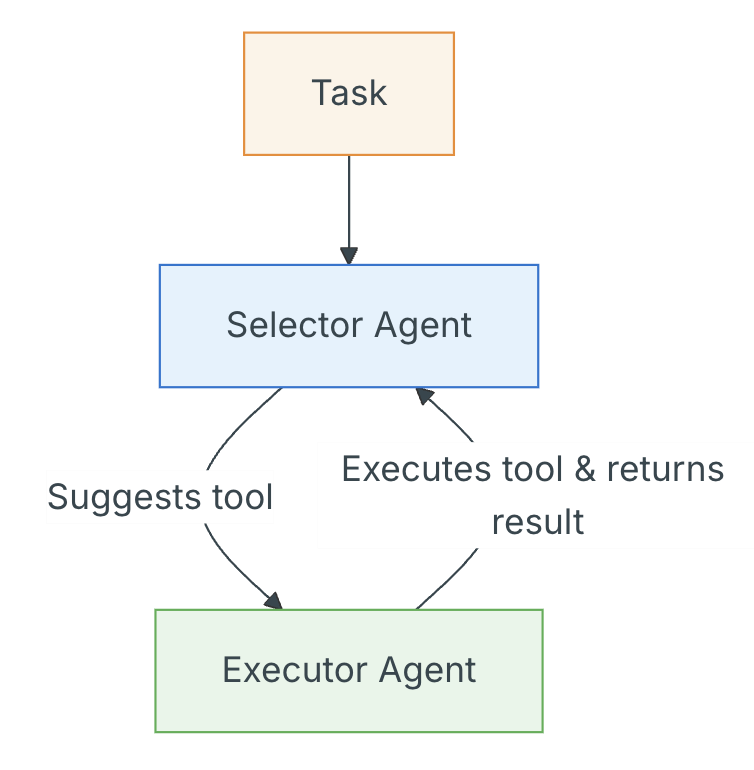



## Enhancing Our Financial System with Tools

Let's enhance our financial compliance system by adding a powerful new capability: duplicate payment detection.

### The Challenge

Duplicate payments are a common problem in financial systems. A company might accidentally pay the same invoice twice, or a fraudster might try to get multiple payments for the same service.

Our current system can detect suspicious transactions but has no way to check if a transaction is a duplicate of one that's already been processed.

### Our Tools Solution

Here's how we'll enhance our system:

- Create a function that checks a transaction against a database of previous payments
- Register this function as a tool that our finance_bot can use
- Modify the workflow to check each transaction for duplicates before processing it
- Automatically reject duplicate payments without requiring human approval
- Implementation: Creating a Duplicate Detection Tool#

First, let's create a function that checks for duplicate payments:

In [5]:
from typing import Annotated, Any
from datetime import datetime, timedelta

from autogen import ConversableAgent, LLMConfig
from autogen.agentchat import initiate_group_chat
from autogen.agentchat.group.patterns import AutoPattern

# Mock database of previous transactions
def get_previous_transactions() -> list[dict[str, Any]]:
    today = datetime.now()
    return [
        {
            "vendor": "Staples",
            "amount": 500,
            "date": (today - timedelta(days=3)).strftime("%Y-%m-%d"),  # 3 days ago
            "memo": "Quarterly supplies",
        },
        {
            "vendor": "Acme Corp",
            "amount": 1500,
            "date": (today - timedelta(days=10)).strftime("%Y-%m-%d"),  # 10 days ago
            "memo": "NDA services",
        },
        {
            "vendor": "Globex",
            "amount": 12000,
            "date": (today - timedelta(days=5)).strftime("%Y-%m-%d"),  # 5 days ago
            "memo": "Confidential",
        },
    ]

get_previous_transactions()

[{'vendor': 'Staples',
  'amount': 500,
  'date': '2025-07-01',
  'memo': 'Quarterly supplies'},
 {'vendor': 'Acme Corp',
  'amount': 1500,
  'date': '2025-06-24',
  'memo': 'NDA services'},
 {'vendor': 'Globex',
  'amount': 12000,
  'date': '2025-06-29',
  'memo': 'Confidential'}]

In [8]:
# Simple duplicate detection function

def check_duplicate_payment(
    vendor: Annotated[str, "The vendor name"],
    amount: Annotated[float, "The transaction amount"],
    memo: Annotated[str, "The transaction memo"]
) -> dict[str, Any]:
    """Check if a transaction appears to be a duplicate of a recent payment"""
    previous_transactions = get_previous_transactions()

    today = datetime.now()

    for tx in previous_transactions:
        tx_date = datetime.strptime(tx["date"], "%Y-%m-%d")
        date_diff = (today - tx_date).days

        # If vendor, memo and amount match, and transaction is within 7 days
        if (
            tx["vendor"] == vendor and
            tx["memo"] == memo and
            tx["amount"] == amount and
            date_diff <= 7
        ):
            return {
                "is_duplicate": True,
                "reason": f"Duplicate payment to {vendor} for ${amount} on {tx['date']}"
            }

    return {
        "is_duplicate": False,
        "reason": "No recent duplicates found"
    }

check_duplicate_payment("Globex", 12000, "Confidential")

{'is_duplicate': True,
 'reason': 'Duplicate payment to Globex for $12000 on 2025-06-29'}

In this code:
- We created a mock database function to simulate retrieving past transactions
- We defined a duplicate detection function that compares a new transaction against past ones
- The function uses Annotated to provide clear parameter descriptions, which helps the agent understand how to use the tool
- The function's docstring will be used to describe the tool to the LLM
- The function checks if the transaction is a duplicate based on vendor, amount, memo and transaction is within 7 days
- It returns a dictionary indicating whether the transaction is a duplicate and why


### Updating Our Agents for Tool Usage

Now let's update our agent system messages to incorporate duplicate checking:

In [9]:
# Define the system message for our finance bot
finance_system_message = """
You are a financial compliance assistant. You will be given a set of transaction descriptions.

For each transaction:
1. First, extract the vendor name, amount, and memo
2. Check if the transaction is a duplicate using the check_duplicate_payment tool
3. If the tool identifies a duplicate, automatically reject the transaction
4. If not a duplicate, continue with normal evaluation:
    - If it seems suspicious (e.g., amount > $10,000, vendor is unusual, memo is vague), ask the human agent for approval
    - Otherwise, approve it automatically

Provide clear explanations for your decisions, especially for duplicates or suspicious transactions.
When all transactions are processed, summarize the results and say "You can type exit to finish".
"""

# Define the system message for the summary agent
summary_system_message = """
You are a financial summary assistant. You will be given a set of transaction details and their approval status.
Your task is to summarize the results of the transactions processed by the finance bot.
Generate a markdown table with the following columns:
- Vendor
- Memo
- Amount
- Status (Approved/Rejected)
- Reason (especially note if rejected due to being a duplicate)

The summary should include the total number of transactions, the number of approved transactions, and the number of rejected transactions.
The summary should be concise and clear.

Once you've generated the summary append the below in the summary:
==== SUMMARY GENERATED ====
"""

# Create the finance agent with LLM intelligence
with llm_config:
    finance_bot = ConversableAgent(
        name="finance_bot",
        system_message=finance_system_message,
        functions=[check_duplicate_payment],
    )
    summary_bot = ConversableAgent(
        name="summary_bot",
        system_message=summary_system_message,
    )

# Create the human agent for oversight
human = ConversableAgent(
    name="human",
    human_input_mode="ALWAYS",  # Always ask for human input
)

With this registration:

- The `finance_bot` can now suggest using the `check_duplicate_payment` tool when appropriate

- We will continue using a Group Chat and an internal tool executor will execute all tool recommendations automatically

### Generating Test Data with Duplicates

Let's create sample transactions that include duplicates:

In [10]:
# Generate new transactions including a duplicate
transactions = [
    "Transaction: $500 to Staples. Memo: Quarterly supplies.",  # Duplicate of an existing transaction
    "Transaction: $4000 to Unicorn LLC. Memo: Reimbursement.",
    "Transaction: $12000 to Globex. Memo: Confidential.",  # Duplicate of an existing transaction
    "Transaction: $22000 to Initech. Memo: Urgent request."
]

# Format the initial message
initial_prompt = (
    "Please process the following transactions one at a time, checking for duplicates:\n\n" +
    "\n".join([f"{i+1}. {tx}" for i, tx in enumerate(transactions)])
)

### Putting It All Together

Now let's run our enhanced financial compliance system with duplicate detection:

In [11]:
def is_termination_msg(msg: dict[str, Any]) -> bool:
    content = msg.get("content", "")
    return (content is not None) and "==== SUMMARY GENERATED ====" in content

pattern = AutoPattern(
    initial_agent=finance_bot,
    agents=[finance_bot, summary_bot],
    user_agent=human,
    group_manager_args = {
        "llm_config": llm_config,
        "is_termination_msg": is_termination_msg
    },
)

result, _, _ = initiate_group_chat(
    pattern=pattern,
    messages=initial_prompt,
)

human (to chat_manager):

Please process the following transactions one at a time, checking for duplicates:

1. Transaction: $500 to Staples. Memo: Quarterly supplies.
2. Transaction: $4000 to Unicorn LLC. Memo: Reimbursement.
3. Transaction: $12000 to Globex. Memo: Confidential.
4. Transaction: $22000 to Initech. Memo: Urgent request.

--------------------------------------------------------------------------------

Next speaker: finance_bot


>>>>>>>> USING AUTO REPLY...
finance_bot (to chat_manager):

***** Suggested tool call (call_chPXQ0ZIeazNHNMf5TnPbf8a): check_duplicate_payment *****
Arguments: 
{"vendor": "Staples", "amount": 500, "memo": "Quarterly supplies"}
****************************************************************************************
***** Suggested tool call (call_YcgHdv9GIFLqzBIrjA1lczp1): check_duplicate_payment *****
Arguments: 
{"vendor": "Unicorn LLC", "amount": 4000, "memo": "Reimbursement"}
*****************************************************************

### Understanding the Enhanced Workflow

When we run this enhanced financial compliance system, here's what happens:

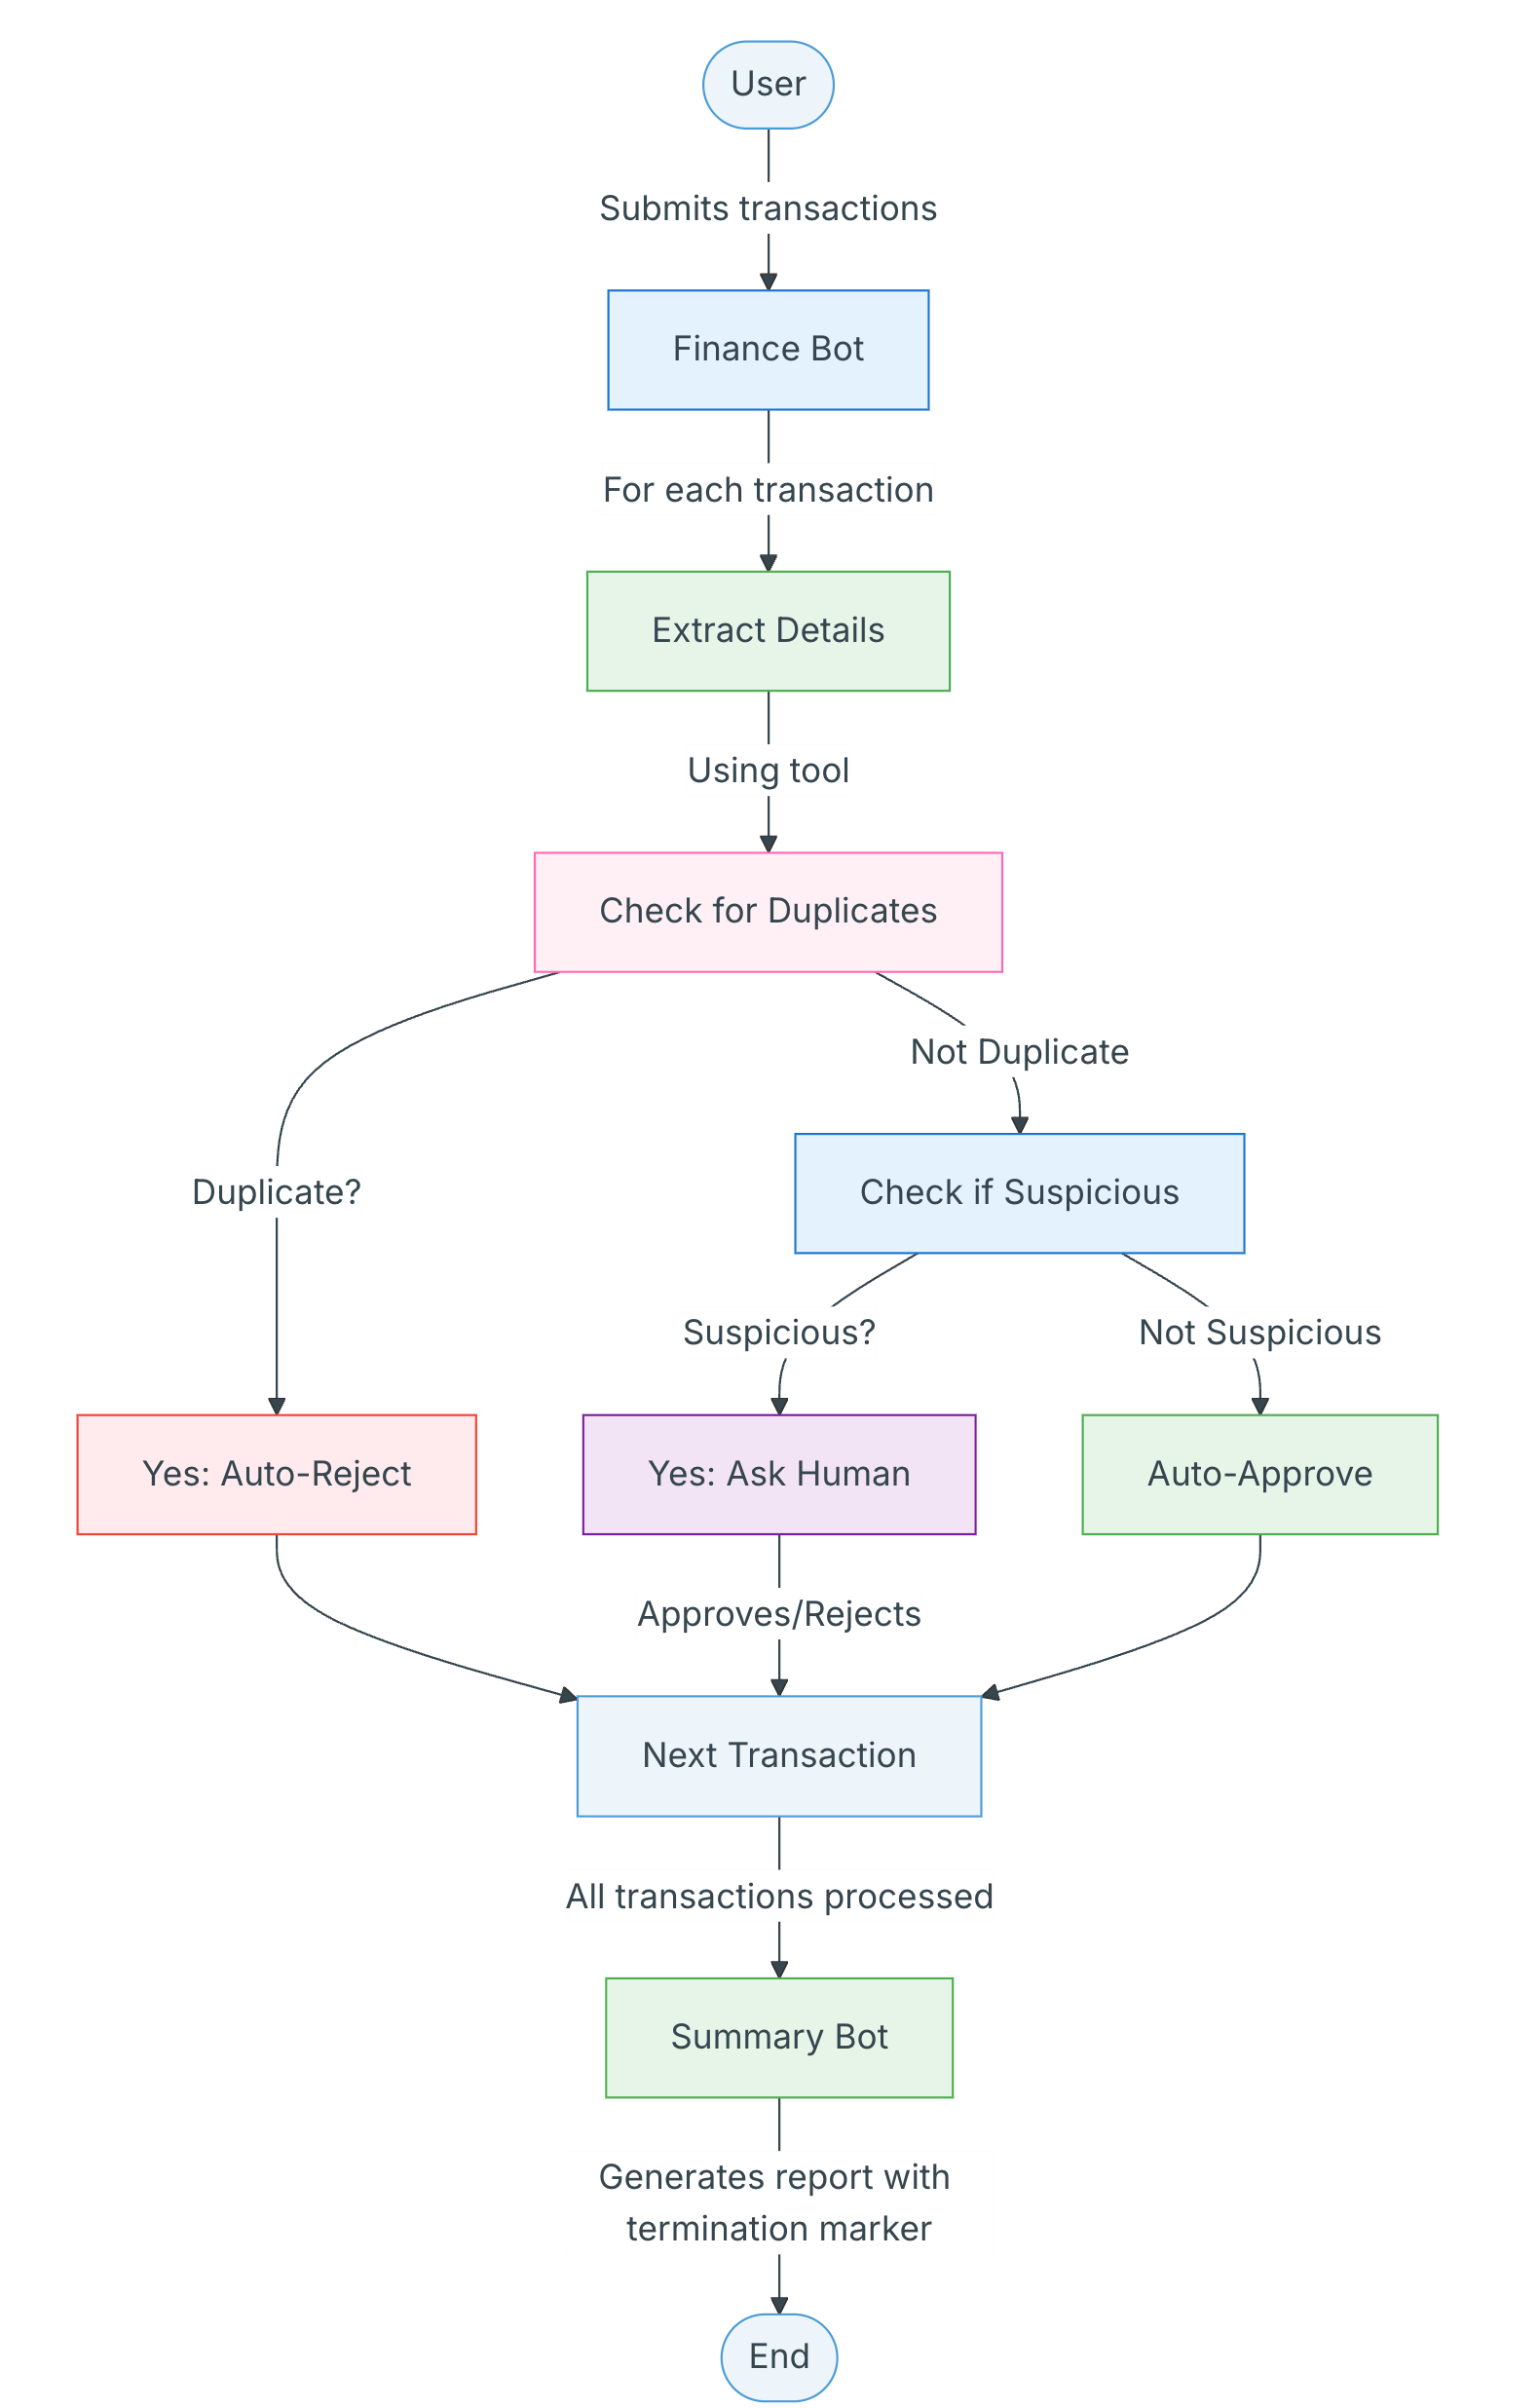